# Distracted Driver Detection

*This notebook is best viewed in Google Colab*

## Background

Compared to other similar cities in first world countries, Singapore has one of the highest [road fatality rates per motor vehicle](https://www.budgetdirect.com.sg/car-insurance/research/road-accident-statistics-in-singapore). One of the main causes of this is distracted driving - in 2016, over 40% of road traffic fatalities here occurred due to [drivers failing to keep a proper lookout](https://www.budgetdirect.com.sg/blog/car-insurance/distracted-driving-the-cost-and-6-ways-to-stay-safe) on roads. Drivers who are using their mobile phones, grabbing a drink or even talking to their fellow passengers tend to pay less attention to their surroundings while driving.

Despite enforcement efforts such as the [ban of using mobile phones while driving](https://kwiksure.sg/blog/distracted-driving/), the problem seems to be quite entrenched here. In fact, a survey showed that over 80% of drivers admitted to [using their mobile phones while driving](https://www.todayonline.com/singapore/83-singapore-drivers-use-their-mobile-phones-while-driving-survey). Ironically, the same survey also showed that over 90% of drivers felt that it was an unsafe practice.

## Problem Statement

In order to improve these statistics and increase road safety, we want to explore whether dashboard cameras can be used to detect drivers who are distracted. We will attempt to create an image classifer model that can detect various distraction states of the driver based on images of the driver.

## Executive Summary

We built a Convolutional Neural Network (CNN) model based on data from a [Kaggle competition](https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview) by State Farm. The data consists of images of drivers split into 10 classes, each representing various states of distraction. Our model aims to predict which class the images belong to and will be evaluated on the test dataset from Kaggle.

We first preprocessed our train and validation datasets in order for our model to achieve the best performance on the test dataset. We used transfer learning with fine-tuning on two pre-trained CNN models - VGG16 & EfficientNetB4. The models were evaluated on multiclass log loss and EfficientNetB4 was chosen as the best model, achieving a score of 0.599. An ensemble method was then used to produce the final predictions for Kaggle, achieving a score of **0.301**.

The performance of the model was then tested on unseen external images to further evaluate its practicality for real world usage.



## Setup & Imports

We will be working on Google Colab for this project - first we conduct some checks to ensure that the GPU is connected & running, then we import the necessary packages and mount Google Drive in the runtime's virtual machine

In [ ]:
# Check GPU connection
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name( )
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Check GPU is running
!nvidia-smi

Tue Jun 29 02:15:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |    347MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Imports
import os
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from glob import glob
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB4

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change working directory
os.chdir("/content/drive/MyDrive/distracted_driver_detection/code")

## Exploratory Data Analysis

The dataset comes with the train & test images, as well as `driver_imgs_list.csv` and `sample_submission.csv`

### Data Download

In [ ]:
# Copy Google Drive location of images zip file
train_zip = 'file:/content/drive/MyDrive/distracted_driver_detection/data/images/train.zip'
test_zip = 'file:/content/drive/MyDrive/distracted_driver_detection/data/images/test.zip'

In [ ]:
# Unzip using keras get_file function
train_zip_dir = tf.keras.utils.get_file(fname='train_zip', origin=train_zip, extract=True)
test_zip_dir = tf.keras.utils.get_file(fname='test_zip', origin=test_zip, extract=True)

3347554304/3347551527 [==============================] - 83s 0us/step


In [ ]:
# Create directory path to unzipped images
train_dir = os.path.join(os.path.dirname(train_zip_dir), 'train')
test_dir = os.path.join(os.path.dirname(test_zip_dir), 'test')
print(train_dir)
print(test_dir)

/root/.keras/datasets/train
/root/.keras/datasets/test


In [ ]:
# Check keras cache
!ls /root/.keras/datasets

test  test_zip	train  train_zip


### Kaggle Information

The important pieces of information that Kaggle gives us are as follows:

1. There are 10 classes
    - Each class corresponds to the driver's action - only one class constitutes safe driving while the other 9 are different states of distraction
2. Metadata such as creation dates are removed
    - This ensures that this becomes a purely computer vision problem (Only image data is available for us to analyse and model)
3. The images are curated from a controlled experiment where a truck is dragging the car around on the streets
    - This means the quality and angle of the photos should be fairly consistent
4. The train images are 640x480 pixels, but the test images have some images that are resized
    - This was done to discourage hand labelling as part of the modelling process
5. The train and test data are split on the drivers
    - One driver can only appear on either the train or the test set
    - This ensures that our model should not train on a particular driver's features and can generalise to other drivers' images
        - We will explore this in detail during the baseline modelling section

A csv file was also provided with information about the train images


In [ ]:
# Read in csv file
train_drivers_df = pd.read_csv('../data/driver_imgs_list.csv')

In [ ]:
train_drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [ ]:
train_drivers_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

The csv file is quite straightforward, displaying the image file name `img` as well as its corresponding class `classname` and driver `subject`

In [ ]:
# No of unique drivers in train dataset
len(train_drivers_df['subject'].unique())

26

In [ ]:
train_drivers_df['subject'].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p081     823
p012     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

There are 26 unique drivers in the train dataset, each with a different number of images ranging from 346 to 1237.

In [ ]:
# Checking for duplicates
train_drivers_df.duplicated().any()

False

### Exploring Images

In [ ]:
# Total no of train photos
len(glob(os.path.join(train_dir, '*', '*')))

22424

In [ ]:
# Total no of test photos
len(glob(os.path.join(test_dir, '*', '*')))

79726

In [ ]:
# Class definitions (from Kaggle)
class_dict = {
    'c0': 'Safe Driving',
    'c1': 'Texting - Right',
    'c2': 'Talking on the Phone - Right',
    'c3': 'Texting - Left',
    'c4': 'Talking on the Phone - Left',
    'c5': 'Operating the Radio',
    'c6': 'Drinking',
    'c7': 'Reaching Behind',
    'c8': 'Hair and Makeup',
    'c9': 'Talking to Passenger'
}

In [ ]:
# Check class balance
classes = sorted(os.listdir(train_dir))
class_balance_df = pd.DataFrame(columns=['class', 'count'])

for class_ in classes:
    row = {'class': class_, 'count': len(glob(os.path.join(train_dir, class_, '*')))}
    class_balance_df = class_balance_df.append(row, ignore_index=True)

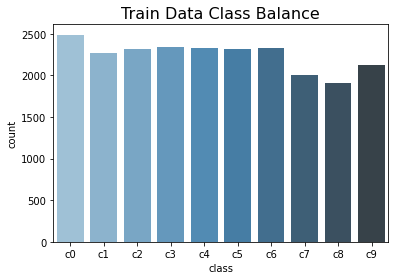

In [ ]:
sns.barplot(
    data=class_balance_df,
    x='class',
    y='count',
    palette='Blues_d',
).set_title('Train Data Class Balance', fontsize=16);

The classes are quite balanced, so we will not be conducting any resampling with the train data

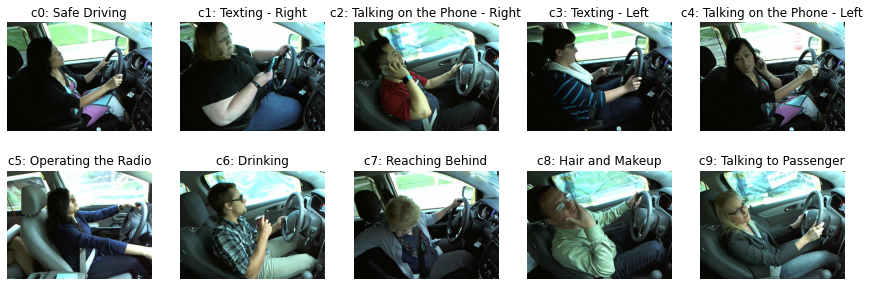

In [ ]:
# Visualise random train images from each label
plt.figure(figsize=(15,5))

for i, class_ in enumerate(classes):
    ax = plt.subplot(2, 5, i + 1)
    im_path = glob(os.path.join(train_dir, class_, '*'))[np.random.randint(1, 1001)]
    image = mpimg.imread(im_path)
    plt.imshow(image)
    plt.title(f'{class_}: {class_dict[class_]}')
    plt.axis('off')

**General Observations**

From visualising random images from each label a few times, we notice a few things:
- The drivers' features are quite different from one another
    - There is no dominant ethnicity, gender, size, hair, clothing or eyewear
- The camera angle is slightly different between drivers, but consistent for different images of the same driver
- Similar types of cars are used for every image
- All the pictures are taken in the daytime, with generally good lighting conditions
- In some camera angles, another person can be seen in the back seat behind the driver

**Observations by Class**

In addition to these general findings, we can also make a few observations for each class:

| Class | Definition                   | Observations                                                                                                                             |
|-------|------------------------------|------------------------------------------------------------------------------------------------------------------------------------------|
| c0    | Safe Driving                 | Both hands on steering wheel, facing forward                                                                                             |
| c1    | Texting - Right              | Left hand on steering wheel, right hand holding phone in front of body,   either facing forward or looking down at phone                 |
| c2    | Talking on the Phone - Right | Left hand on steering wheel, right hand holding phone to right ear, facing forward                                                       |
| c3    | Texting - Left               | Right hand on steering wheel, left hand holding phone in front of body, either facing forward or looking down at phone                   |
| c4    | Talking on the Phone - Left  | Right hand on steering wheel, left hand holding phone to left ear, facing forward                                                        |
| c5    | Operating the Radio          | Left hand on steering wheel, right hand reaching towards radio on the right of steering wheel, either facing forward or looking at radio |
| c6    | Drinking                     | Either hand on steering wheel, other hand holding cup/bottle in front of body or face, facing forward                                    |
| c7    | Reaching Behing              | Left hand on steering wheel, right hand reaching behind, either facing forward or looking behind                                                                 |
| c8    | Hair and Makeup              | Either hand on steering wheel, other hand touching face, either facing forward or up towards sun visor                                   |
| c9    | Talking to Passenger         | Either one or both hands on steering wheel, facing towards passenger on the right                                                        |

Classes `c0`, `c8` and `c9` in particular seem to be quite similar to each other, so it would be interesting to see how our model deals with these classes.

**Insights from Observations**

From these observations, we can hypothesise that in order for our model to do well, it should be able to classify the images primarily based on the driver's body position as it seems to be the most distinguishing feature. Most other features are either consistent across classes (e.g. type of car, lighting conditions) or inconsistent within the same class (e.g. driver features, camera angle). We will keep this in mind when evaluating our model later on.

### Distinct Driver Issue

One key takeaway from the data exploration is that the **train and test data are split by drivers**. This means that we need to ensure that our model can generalise to new data, i.e. new drivers. Another thing to note is that the images are curated from a controlled experiment, meaning that the train data could have very similar images that were probably taken sequentially during the experiment.

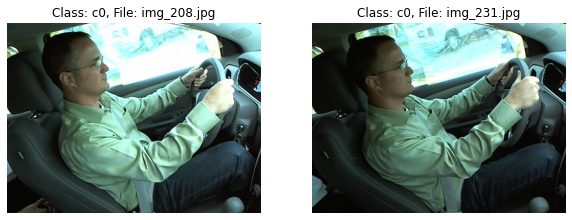

In [ ]:
# Example of similar images in train dataset
plt.figure(figsize=(10, 5))

for i, img in enumerate(['img_208.jpg', 'img_231.jpg']):
    ax = plt.subplot(1, 2, i + 1)
    im_path = os.path.join(train_dir, 'c0', img)
    im = mpimg.imread(im_path)
    plt.imshow(im)
    plt.title(f'Class: c0, File: {img}')
    plt.axis('off')

One issue that this brings up is that our model could end up overfitting to the driver's features, especially if similar images like above are separated into the train and validation sets. Ideally, as explored before, the model is able to recognise and focus on the driver's body position so that it can still perform well when introduced to unseen data (i.e. drivers outside the train set).

Of course, CNN models are generally quite good for image classification and could still be able to perform well despite this issue. We will do a quick experiment with randomly shuffled train data below to explore this issue further.

## Trial Model

We will be using transfer learning from a pre-trained CNN model: **VGG16**. We will go into more detail regarding transfer learning and model methodology in the modelling section later on, here we will simply carry out a trial run of the untuned model for the purposes of investigating the distinct driver issue mentioned above.



### Creating Image Datasets

A mentioned earlier, we will be randomly shuffling our train images into train and validation sets (regardless of driver), which we will then use to train our base model.

In [ ]:
# Loading train images into tf datasets, split into train & validation sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=128,
    image_size=(224, 224),
    shuffle=True,
    seed=43,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=128,
    image_size=(224, 224),
    shuffle=True,
    seed=43,
    validation_split=0.2,
    subset='validation'
)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


In [ ]:
# Checking classes
class_names = train_ds.class_names
class_names

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
# Checking batch image size & label shape
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(128, 224, 224, 3)
(128, 10)


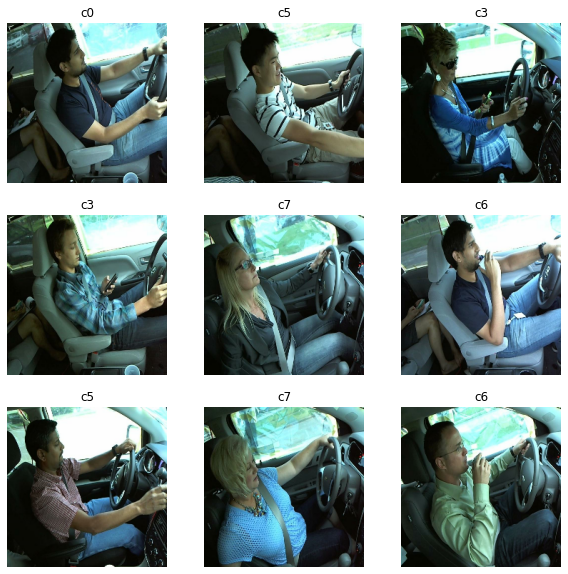

In [ ]:
# Visualising first 9 images in train dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Trial VGG16 Setup

In [ ]:
# Instantiate the base model
base_vgg = VGG16(
    include_top=False,  # Remove prediction layers
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'   # Add a global average pooling layer to make the output a 2D tensor
)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze base VGG16 model so that weights are preserved while training
base_vgg.trainable = False

In [ ]:
# Use Keras functional API to add prediction layers
vgg_input = base_vgg.output
x = Dropout(0.2)(vgg_input)
x = Dense(128, activation='relu')(x)
vgg_output = Dense(10, activation='softmax')(x)
base_vgg_model = Model(inputs=base_vgg.input, outputs=vgg_output)

In [ ]:
base_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Callbacks

We will be using 3 callbacks during the model training process:
1. `ModelCheckpoint` to save the model & weights during the training process
2. `EarlyStopping` to stop the training process once the model stops improving for a certain number of epochs
3. `ReduceLROnPlateau` to reduce the learning rate once the model stops improving for a smaller number of epochs

In [ ]:
def checkpoint(model_name):
    filepath = '../models/checkpoints/' + model_name + '_checkpoint.hdf5'
    return ModelCheckpoint(
        filepath,
        verbose=1,
        save_best_only=True,
        mode='auto'
    )

base_vgg_checkpoint = checkpoint('base_vgg')

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=8,
    min_delta=0.001,
    restore_best_weights=True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
   monitor='val_loss',
   verbose=1, 
   factor=0.2, 
   patience=4,
   mode='auto', 
   min_delta=0.001, 
   min_lr=0.00001
)

In [ ]:
# Compile model
base_vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Fit Model & Make Predictions

In [ ]:
# Fit baseline model to randomly shuffled train & validation data
base_vgg_history = base_vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[base_vgg_checkpoint, early_stop, reduce_lr]
)

Epoch 1/25
141/141 [==============================] - 69s 310ms/step - loss: 2.5695 - accuracy: 0.3048 - val_loss: 1.0707 - val_accuracy: 0.6775

Epoch 00001: val_loss improved from inf to 1.07071, saving model to ../models/checkpoints/base_vgg_checkpoint.hdf5
Epoch 2/25
141/141 [==============================] - 41s 288ms/step - loss: 1.1265 - accuracy: 0.6181 - val_loss: 0.4952 - val_accuracy: 0.8651

Epoch 00002: val_loss improved from 1.07071 to 0.49515, saving model to ../models/checkpoints/base_vgg_checkpoint.hdf5
Epoch 3/25
141/141 [==============================] - 41s 287ms/step - loss: 0.7189 - accuracy: 0.7545 - val_loss: 0.2861 - val_accuracy: 0.9248

Epoch 00003: val_loss improved from 0.49515 to 0.28608, saving model to ../models/checkpoints/base_vgg_checkpoint.hdf5
Epoch 4/25
141/141 [==============================] - 41s 288ms/step - loss: 0.5251 - accuracy: 0.8268 - val_loss: 0.2108 - val_accuracy: 0.9478

Epoch 00004: val_loss improved from 0.28608 to 0.21085, saving 

We will also be creating predictions on the actual test dataset, which we will then submit to Kaggle to get the test score. The submissions are evaluated using the [multi-class logarithmic loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression).

In [ ]:
# Load test images into test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=None,
    color_mode='rgb',
    batch_size=128,
    image_size=(224, 224),
    shuffle=False
)

Found 79726 files belonging to 1 classes.


In [ ]:
# Make predictions
test_preds = base_vgg_model.predict(test_ds)

In [ ]:
# Read sample submission csv
sample_sub = pd.read_csv('../data/sample_submission.csv')
sample_sub.head()

img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
0       img_1.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
1      img_10.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
2     img_100.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
3    img_1000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
4  img_100000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1

In [ ]:
# Create submission df
sub = pd.DataFrame(test_preds, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
sub['img'] = sample_sub['img']
sub = sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']]
sub.head()

img            c0            c1  ...            c7        c8        c9
0       img_1.jpg  1.765809e-06  8.159065e-08  ...  9.667793e-07  0.002531  0.180826
1      img_10.jpg  9.693122e-02  1.729045e-05  ...  2.550856e-02  0.646526  0.197946
2     img_100.jpg  9.830729e-01  1.582037e-02  ...  1.343019e-05  0.000101  0.000976
3    img_1000.jpg  2.867252e-09  1.112130e-09  ...  1.260591e-09  0.999938  0.000003
4  img_100000.jpg  7.815166e-05  3.217582e-03  ...  1.145576e-02  0.955772  0.003311

[5 rows x 11 columns]

In [ ]:
# Check submission shape
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79726 entries, 0 to 79725
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   img     79726 non-null  object 
 1   c0      79726 non-null  float32
 2   c1      79726 non-null  float32
 3   c2      79726 non-null  float32
 4   c3      79726 non-null  float32
 5   c4      79726 non-null  float32
 6   c5      79726 non-null  float32
 7   c6      79726 non-null  float32
 8   c7      79726 non-null  float32
 9   c8      79726 non-null  float32
 10  c9      79726 non-null  float32
dtypes: float32(10), object(1)
memory usage: 3.6+ MB


In [ ]:
# Export to csv
sub.to_csv('../data/base_vgg_submission.csv', index=False)

Trial Model Kaggle Score: **1.78549**

### Evaluation

In [ ]:
# Create function to visualise model performance
def evaluate_model(model, model_history, validation_set, name, 
                   fine_tune=0, fine_history=[], fine_epoch=[]):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax = ax.ravel()

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    if fine_tune:
        colors = ['green', 'purple', 'saddlebrown']
        for i in range(fine_tune):
            # Epoch where fine-tuning begins
            ax[0].axvline(fine_epoch[i], ls='dotted', color=colors[i], 
                          label=f'Fine Tuning {i+1}')
            ax[1].axvline(fine_epoch[i], ls='dotted', color=colors[i], 
                          label=f'Fine Tuning {i+1}')

            loss += fine_history[i].history['loss']
            val_loss += fine_history[i].history['val_loss']
            acc += fine_history[i].history['accuracy']
            val_acc += fine_history[i].history['val_accuracy']

    ax[0].plot(loss, color='royalblue', label='Training Loss')
    ax[0].plot(val_loss, color='orangered', label='Validation Loss')
    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss (Categorical Crossentropy)')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper right')

    ax[1].plot(acc, color='royalblue', label='Training Accuracy')
    ax[1].plot(val_acc, color='orangered', label='Validation Accuracy')
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')

    metrics = model.evaluate(validation_set)
    fig.suptitle(f'{name} - Validation Loss: {metrics[0]:.3f}, \
    Validation Accuracy: {metrics[1]:.3f}', fontsize=16)

36/36 [==============================] - 9s 221ms/step - loss: 0.0362 - accuracy: 0.9915


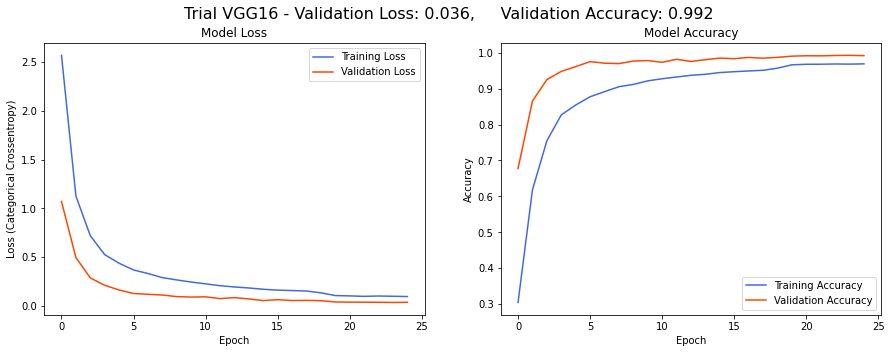

In [ ]:
evaluate_model(base_vgg_model, base_vgg_history, val_ds, 'Trial VGG16')

As seen above, the validation loss is consistently lower than the train loss (and vice versa for accuracy). This is of interest as we would expect the model to perform better during training than on the validation set. There are a couple of reasons that could explain this behaviour as outlined [here](https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/), however it is also mentioned that the most common reason for validation loss being lower than training loss is due to the data distribution itself.

The model performed quite well given the shuffled data - **0.049** loss & 98.7% accuracy. However, when exposed to unseen data in the form of the actual test set, the model only achieved a loss of **1.785**. 

Having observed these, we can infer that the reason for this disparity is due to what we had found during the data exploration - the driver split. The baseline model could be overfitting to the drivers' features which leads to great validation results, but does not perform nearly as well when exposed to images of new drivers.

## Preprocessing - Split Data by Driver



In order to overcome the distinct driver issue explored above, we will not split the data completely randomly. Instead, we will be splitting the data by drivers, i.e. photos of certain drivers will be in the train dataset and the rest will be in the validation dataset. Since there will be no overlap of photos of the same driver between the train and validation datasets, our model should avoid overfitting on the drivers' features and perform better when exposed to new images of unseen drivers.

In [ ]:
# Create list of unique drivers in train dataset
fulltrain_driver_list = train_drivers_df['subject'].unique().tolist()
len(fulltrain_driver_list)

26

In [ ]:
# Instantiate a KFold split that will be used to split drivers
kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:
# Visualise index splits
for train_index, val_index in kf.split(fulltrain_driver_list):
    print(train_index, val_index)

[ 1  2  3  4  5  6  7 10 12 14 15 17 18 19 20 21 22 23 25] [ 0  8  9 11 13 16 24]
[ 0  4  6  7  8  9 10 11 13 14 16 17 18 19 20 21 22 24 25] [ 1  2  3  5 12 15 23]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 19 20 23 24] [ 4 17 18 21 22 25]
[ 0  1  2  3  4  5  8  9 11 12 13 15 16 17 18 21 22 23 24 25] [ 6  7 10 14 19 20]


### Creating Reference Dataframes

For our model selection process, we will only be using one of the splits from above. We will create reference dataframes that will be used to create the datasets before the modelling process.

In [ ]:
train_index, val_index = next(kf.split(fulltrain_driver_list))

In [ ]:
# define function to add image path to df
def add_img_path(df):
    classname = df['classname']
    filename = df['img']
    directory = '/root/.keras/datasets/train'
    return os.path.join(directory, classname, filename)

In [ ]:
# define function to filter & process df
def filter_process_df(df, driver):
    driver_imgs = train_drivers_df.loc[train_drivers_df['subject'] == driver, :]
    df = df.merge(driver_imgs, how='outer')
    df['img_path'] = df.apply(add_img_path, axis=1)
    df['classnumber'] = df['classname'].map(lambda x: int(x.replace('c', '')))
    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle rows in df
    return df

In [ ]:
# Instantiate empty df
train_df = pd.DataFrame(columns=['subject', 'classname', 'img'])
val_df = train_df.copy()

# Fill train df with drivers in train split
train_driver_list = [fulltrain_driver_list[i] for i in train_index]
for train_driver in train_driver_list:
    train_df = filter_process_df(train_df, train_driver)

# Fill val df with drivers in val split
val_driver_list = [fulltrain_driver_list[i] for i in val_index]
for val_driver in val_driver_list:
    val_df = filter_process_df(val_df, val_driver)

In [ ]:
# Check train dataframe
train_df.head()

subject classname  ...                                      img_path classnumber
0    p081        c0  ...  /root/.keras/datasets/train/c0/img_63318.jpg           0
1    p052        c4  ...  /root/.keras/datasets/train/c4/img_40889.jpg           4
2    p049        c5  ...  /root/.keras/datasets/train/c5/img_75640.jpg           5
3    p016        c5  ...  /root/.keras/datasets/train/c5/img_74964.jpg           5
4    p015        c0  ...  /root/.keras/datasets/train/c0/img_79538.jpg           0

[5 rows x 5 columns]

In [ ]:
train_df['subject'].unique()

array(['p081', 'p052', 'p049', 'p016', 'p015', 'p051', 'p014', 'p047',
       'p066', 'p024', 'p056', 'p012', 'p021', 'p061', 'p039', 'p042',
       'p072', 'p022', 'p064'], dtype=object)

In [ ]:
# Check validation dataframe
val_df.head()

subject classname  ...                                      img_path classnumber
0    p026        c7  ...  /root/.keras/datasets/train/c7/img_74538.jpg           7
1    p026        c7  ...  /root/.keras/datasets/train/c7/img_90067.jpg           7
2    p045        c8  ...  /root/.keras/datasets/train/c8/img_32089.jpg           8
3    p002        c1  ...  /root/.keras/datasets/train/c1/img_99248.jpg           1
4    p026        c2  ...  /root/.keras/datasets/train/c2/img_80101.jpg           2

[5 rows x 5 columns]

In [ ]:
val_df['subject'].unique()

array(['p026', 'p045', 'p002', 'p075', 'p035', 'p050', 'p041'],
      dtype=object)

### Recreating Image Datasets (Split by Driver)

We will then use these reference dataframes to create the new image datasets that are split by driver. Later on, we will explore the use of 2 pre-trained models: VGG16 and EfficientNetB4. We will be creating a different dataset for each model because of differing input sizes.

In [ ]:
# define function to convert constant tensors to image data & one-hot encoded labels
def _parse_function(filepath, label):
    img_string = tf.io.read_file(filepath)  # read contents of file from path
    img_decoded = tf.image.decode_jpeg(img_string, channels=3)  # decode jpg img
    img_resized = tf.image.resize(img_decoded, [imgsize, imgsize]) # resize based on model input
    one_hot_label = tf.one_hot(label, num_classes) # create one-hot tensor from single class label
    return img_resized, one_hot_label

In [ ]:
# define function to create dataset from df
def create_img_dataset(df, imgsize, batchsize):
    # Create constant tensors from df
    filepaths = tf.constant(df['img_path'].tolist())
    labels = tf.constant(df['classnumber'].tolist())

    # Create dataset from constant tensors & apply parsing function
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batchsize)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

#### VGG16

In [ ]:
# VGG16 input image size - 224x224x3
imgsize = 224
batchsize = 128
num_classes = 10
vgg_train_ds = create_img_dataset(train_df, imgsize, batchsize)
vgg_val_ds = create_img_dataset(val_df, imgsize, batchsize)

In [ ]:
# Checking batch image size & label shape
for image_batch, labels_batch in vgg_train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(128, 224, 224, 3)
(128, 10)


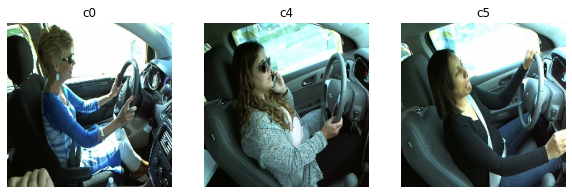

In [ ]:
# Visualising first 3 images in train dataset to ensure consistency
plt.figure(figsize=(10, 10))
for images, labels in vgg_train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

#### EfficientNetB4

In [ ]:
# EfficientNetB4 input image size - 380x380x3
imgsize = 380
enet_train_ds = create_img_dataset(train_df, imgsize, batchsize)
enet_val_ds = create_img_dataset(val_df, imgsize, batchsize)

In [ ]:
# Checking batch image size & label shape
for image_batch, labels_batch in enet_train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(128, 380, 380, 3)
(128, 10)


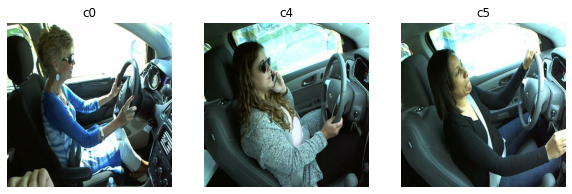

In [ ]:
# Visualising first 3 images in train dataset to ensure consistency
plt.figure(figsize=(10, 10))
for images, labels in enet_train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

## Modelling

As mentioned above, we will assess the performance of 2 different models on the same image data split by driver and then select the best model.

### Methodology

We will be conducting transfer learning and fine-tuning on each pre-trained CNN model. After doing so, we will create predictions on the test dataset and submit the predictions to Kaggle for evaluation. We will also study the loss and validation of each model, then select the best model for further evaluation.

#### Transfer Learning

The reason we are using transfer learning is that the pre-trained models can effectively serve as a generic model of the visual world given that they were trained on such a large and general dataset (`imagenet`). The architectures of these models are also highly optimised to extract meaningful features from images. 

We do not retrain the entire model, but instead simply add the specific classifier for our dataset on top of the pre-trained model so that the feature maps learned previously can be repurposed for this project.

#### Fine-Tuning

Initially, we freeze the layers of the base pre-trained model so that the initial weights are not updated during training. However, we can still increase the performance of the model by retraining a few of the top layers of the base model as these layers are usually more specialised than the lower layers.

In addition to the final classifier layers, we also unfreeze a few of the top layers of the base pre-trained model so that they can be fine-tuned to the specific features of our image dataset. By doing this, we are adapting the specialised upper layers to the features of our dataset.

In [ ]:
# Create function to set a number of top layers to be trainable
def set_trainable_layers(model, layers_from_top):
    model.trainable = True
    for layer in model.layers[:-layers_from_top]:
        layer.trainable = False

    print('Trainable Layers:')
    print()
    counter = 0
    for layer in model.layers:
        # Batch Normalization layers
        if ('bn' in layer.name or 'batch_normalization' in layer.name):
            layer.trainable = False
        # Check
        if layer.trainable == True:
            counter += 1
            print(f'{counter}: {layer.name}')

#### Metrics & Baseline Score

We will be tracking the categorical crossentropy loss, accuracy and Kaggle submission score ([Multi-class logarithmic loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)) for each model, then compare them at the end.

From the Kaggle competition, the sample submission benchmark (where probability of every class for every image is predicted to be equal: 0.1) is **2.30258**. This represents the score that our models *must* beat.

### VGG16

VGG16 is a CNN model developed by the Visual Geometry Group from Oxford (thus the name VGG). It contains 5 convolutional blocks followed by 3 fully connected layers. The model achieves 90.1% top-5 test accuracy in Imagenet, which is a dataset which contains over 14 million labeled images belonging to 1000 classes. The model architecture can be visualised below:

![VGG16 Architecture](https://drive.google.com/uc?id=1IpgApUX66Yzq4W-UYjb0DDsPivHPwydz)

[Source](https://www.researchgate.net/figure/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only_fig3_322512435)



#### Model Setup

In [ ]:
# Instantiate the base model
base_vgg = VGG16(
    include_top=False,  # Remove prediction layers
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'   # Add a global average pooling layer to make the output a 2D tensor
)

In [ ]:
# Freeze base VGG16 model so that weights are preserved while training
base_vgg.trainable = False

In [ ]:
# Use Keras functional API to add prediction layers
vgg_input = base_vgg.output
x = Dropout(0.2)(vgg_input)
x = Dense(128, activation='relu')(x)
vgg_output = Dense(10, activation='softmax')(x)
vgg_model = Model(inputs=base_vgg.input, outputs=vgg_output)

In [ ]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Create checkpoint callback for this model
vgg_checkpoint = checkpoint('vgg16')

In [ ]:
# Compile model
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Fit Model

In [ ]:
# Fit base model to train & validation data split by driver
vgg_history = vgg_model.fit(
    vgg_train_ds,
    validation_data=vgg_val_ds,
    epochs=25,
    callbacks=[vgg_checkpoint, early_stop, reduce_lr]
)

Epoch 1/25
131/131 [==============================] - 49s 371ms/step - loss: 2.9976 - accuracy: 0.3073 - val_loss: 1.8861 - val_accuracy: 0.4044

Epoch 00001: val_loss improved from inf to 1.88610, saving model to ../models/checkpoints/vgg16_checkpoint.hdf5
Epoch 2/25
131/131 [==============================] - 38s 291ms/step - loss: 1.0513 - accuracy: 0.6463 - val_loss: 1.5495 - val_accuracy: 0.5314

Epoch 00002: val_loss improved from 1.88610 to 1.54950, saving model to ../models/checkpoints/vgg16_checkpoint.hdf5
Epoch 3/25
131/131 [==============================] - 38s 291ms/step - loss: 0.6531 - accuracy: 0.7813 - val_loss: 1.4314 - val_accuracy: 0.5816

Epoch 00003: val_loss improved from 1.54950 to 1.43141, saving model to ../models/checkpoints/vgg16_checkpoint.hdf5
Epoch 4/25
131/131 [==============================] - 38s 292ms/step - loss: 0.4786 - accuracy: 0.8420 - val_loss: 1.5282 - val_accuracy: 0.5658

Epoch 00004: val_loss did not improve from 1.43141
Epoch 5/25
131/131 [=

#### Fine-Tuning

We will conduct two fine-tuning steps - first by unfreezing layer 5, then layer 4

In [ ]:
# Unfreeze Block 5
set_trainable_layers(vgg_model, 8)

Trainable Layers:

1: block5_conv1
2: block5_conv2
3: block5_conv3
4: block5_pool
5: global_average_pooling2d_1
6: dropout_1
7: dense_2
8: dense_3


In [ ]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Recompile model with lower learning rate
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training model
vgg_fine1_epochs = vgg_history.epoch[-1]
vgg_total_epochs = vgg_fine1_epochs + 25

vgg_history_fine1 = vgg_model.fit(
    vgg_train_ds,
    validation_data=vgg_val_ds,
    epochs=vgg_total_epochs,
    initial_epoch=vgg_fine1_epochs,
    callbacks=[vgg_checkpoint, early_stop, reduce_lr]
)

Epoch 14/38
131/131 [==============================] - 44s 323ms/step - loss: 0.3420 - accuracy: 0.8995 - val_loss: 0.9032 - val_accuracy: 0.7715

Epoch 00014: val_loss improved from 1.36814 to 0.90323, saving model to ../models/checkpoints/vgg16_checkpoint.hdf5
Epoch 15/38
131/131 [==============================] - 42s 321ms/step - loss: 0.0364 - accuracy: 0.9908 - val_loss: 0.9329 - val_accuracy: 0.7866

Epoch 00015: val_loss did not improve from 0.90323
Epoch 16/38
131/131 [==============================] - 42s 321ms/step - loss: 0.0183 - accuracy: 0.9945 - val_loss: 0.6696 - val_accuracy: 0.8232

Epoch 00016: val_loss improved from 0.90323 to 0.66960, saving model to ../models/checkpoints/vgg16_checkpoint.hdf5
Epoch 17/38
131/131 [==============================] - 42s 321ms/step - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.6725 - val_accuracy: 0.8381

Epoch 00017: val_loss did not improve from 0.66960
Epoch 18/38
131/131 [==============================] - 42s 321ms/step - loss: 

In [ ]:
# Second round of fine tuning, Unfreeze Block 4
set_trainable_layers(vgg_model, 12)

Trainable Layers:

1: block4_conv1
2: block4_conv2
3: block4_conv3
4: block4_pool
5: block5_conv1
6: block5_conv2
7: block5_conv3
8: block5_pool
9: global_average_pooling2d_1
10: dropout_1
11: dense_2
12: dense_3


In [ ]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Recompile model with lower learning rate
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training model
vgg_fine2_epochs = vgg_history_fine1.epoch[-1]
vgg_total_epochs = vgg_fine2_epochs + 25

vgg_history_fine2 = vgg_model.fit(
    vgg_train_ds,
    validation_data=vgg_val_ds,
    epochs=vgg_total_epochs,
    initial_epoch=vgg_fine2_epochs,
    callbacks=[vgg_checkpoint, early_stop, reduce_lr]
)

Epoch 30/54
131/131 [==============================] - 56s 414ms/step - loss: 0.0201 - accuracy: 0.9940 - val_loss: 0.6200 - val_accuracy: 0.8525

Epoch 00030: val_loss did not improve from 0.61140
Epoch 31/54
131/131 [==============================] - 54s 410ms/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 0.8296 - val_accuracy: 0.8024

Epoch 00031: val_loss did not improve from 0.61140
Epoch 32/54
131/131 [==============================] - 54s 410ms/step - loss: 0.0154 - accuracy: 0.9957 - val_loss: 0.8886 - val_accuracy: 0.8588

Epoch 00032: val_loss did not improve from 0.61140
Epoch 33/54
131/131 [==============================] - 54s 410ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.6685 - val_accuracy: 0.8664

Epoch 00033: val_loss did not improve from 0.61140
Epoch 34/54
131/131 [==============================] - 54s 410ms/step - loss: 7.6804e-04 - accuracy: 0.9998 - val_loss: 0.7294 - val_accuracy: 0.8846

Epoch 00034: val_loss did not improve from 0.61140

Epoch

#### Make Predictions

In [ ]:
# Load test images into test dataset
vgg_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=None,
    color_mode='rgb',
    batch_size=128,
    image_size=(224, 224),
    shuffle=False
)

Found 79726 files belonging to 1 classes.


In [ ]:
# Make predictions on test dataset
vgg_test_preds = vgg_model.predict(vgg_test_ds)

In [ ]:
# Create submission df
vgg_sub = pd.DataFrame(vgg_test_preds, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
vgg_sub['img'] = sample_sub['img']
vgg_sub = vgg_sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']]
vgg_sub.head()

img            c0  ...            c8            c9
0       img_1.jpg  1.315786e-04  ...  4.142993e-04  1.786432e-03
1      img_10.jpg  6.176265e-07  ...  1.233595e-10  8.908268e-09
2     img_100.jpg  8.181880e-02  ...  7.207433e-02  4.255511e-01
3    img_1000.jpg  2.014288e-11  ...  9.999787e-01  3.715475e-09
4  img_100000.jpg  3.520439e-04  ...  4.384661e-06  2.301349e-06

[5 rows x 11 columns]

In [ ]:
# Check submission shape
vgg_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79726 entries, 0 to 79725
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   img     79726 non-null  object 
 1   c0      79726 non-null  float32
 2   c1      79726 non-null  float32
 3   c2      79726 non-null  float32
 4   c3      79726 non-null  float32
 5   c4      79726 non-null  float32
 6   c5      79726 non-null  float32
 7   c6      79726 non-null  float32
 8   c7      79726 non-null  float32
 9   c8      79726 non-null  float32
 10  c9      79726 non-null  float32
dtypes: float32(10), object(1)
memory usage: 3.6+ MB


In [ ]:
# Export to csv
vgg_sub.to_csv('../data/vgg_submission.csv', index=False)

VGG16 Fine-Tuned Model Kaggle Score: **0.68395**

#### Evaluation

45/45 [==============================] - 10s 214ms/step - loss: 0.6200 - accuracy: 0.8525


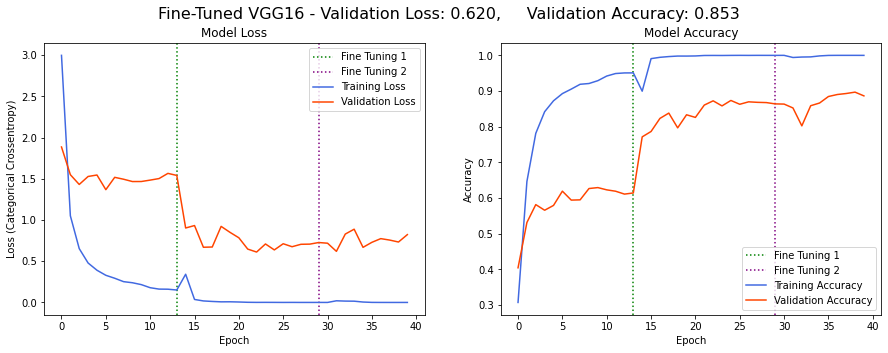

In [ ]:
evaluate_model(vgg_model, vgg_history, vgg_val_ds, 'Fine-Tuned VGG16', 
               fine_tune=2, fine_history=[vgg_history_fine1, vgg_history_fine2],
               fine_epoch=[vgg_fine1_epochs, vgg_fine2_epochs])

As seen above, the training loss here quickly become less than the validation loss (and vice versa for accuracy) when we split the data by drivers. A drastic improvement in model performance can also be seen immediately after the model begun to be fine-tuned. However, the model performance did not increase when a further layer was unfrozen, indicating that the weights of the base VGG16 model were more valuable than adapting those layers to our dataset. We will analyse the performance more later on.

### EfficientNetB4

EfficientNet was introduced by Google in 2019 and focused on producing better results while using considerably fewer numbers of parameters as compared to other similar CNN models. It consists of several modules which are repeated and linked to one another in a number of blocks. 

EfficientNet has 8 different architectures, from B0 to B7. We will be using B4 as it achieves a good balance of performance and size. The architecture is as below:

![EfficientNetB4 Architecture](https://drive.google.com/uc?id=12zRWZsKZRsti_f0SYZUnOpnLFxu_haB2)
[Source](https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142)

#### Model Setup

In [ ]:
# Instantiate the base model
base_enet = EfficientNetB4(
    include_top=False,  # Remove prediction layers
    weights='imagenet',
    input_shape=(380, 380, 3),
    pooling='avg'   # Add a global average pooling layer to make the output a 2D tensor
)

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
# Freeze base EfficientNetB4 model so that weights are preserved while training
base_enet.trainable = False

In [ ]:
# Use Keras functional API to add prediction layers
enet_input = base_enet.output
x = Dropout(0.2)(enet_input)
x = Dense(128, activation='relu')(x)
enet_output = Dense(10, activation='softmax')(x)
enet_model = Model(inputs=base_enet.input, outputs=enet_output)

In [ ]:
enet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
# Create checkpoint callback for this model
enet_checkpoint = checkpoint('enetB4')

In [ ]:
# Compile model
enet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Fit Model

In [ ]:
# Fit base model to train & validation data split by driver
enet_history = enet_model.fit(
    enet_train_ds,
    validation_data=enet_val_ds,
    epochs=25,
    callbacks=[enet_checkpoint, early_stop, reduce_lr]
)

Epoch 1/25
131/131 [==============================] - 193s 1s/step - loss: 0.9313 - accuracy: 0.7274 - val_loss: 0.8488 - val_accuracy: 0.7468

Epoch 00001: val_loss improved from inf to 0.84877, saving model to ../models/checkpoints/enetB4_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
131/131 [==============================] - 158s 1s/step - loss: 0.3571 - accuracy: 0.9111 - val_loss: 0.7787 - val_accuracy: 0.7594

Epoch 00002: val_loss improved from 0.84877 to 0.77866, saving model to ../models/checkpoints/enetB4_checkpoint.hdf5
Epoch 3/25
131/131 [==============================] - 158s 1s/step - loss: 0.2515 - accuracy: 0.9330 - val_loss: 0.7948 - val_accuracy: 0.7394

Epoch 00003: val_loss did not improve from 0.77866
Epoch 4/25
131/131 [==============================] - 158s 1s/step - loss: 0.2027 - accuracy: 0.9460 - val_loss: 0.7485 - val_accuracy: 0.7660

Epoch 00004: val_loss improved from 0.77866 to 0.74849, saving model to ../models/checkpoints/enetB4_checkpoint.hdf5
Epoch 5/25
131/131 [==============================] - 158s 1s/step - loss: 0.1738 - accuracy: 0.9532 - val_loss: 0.8051 - val_accuracy: 0.7454

Epoch 00005: val_loss did not improve from 0.74849
Epoch 6/25
131/131 [==============================] - 158s 1s/step - loss: 0.1539 - accu

#### Fine-Tuning

We will conduct two fine-tuning steps - first by unfreezing layer 7b, then layer 7a

In [ ]:
# Unfreeze Block 7b
set_trainable_layers(enet_model, 22)

Trainable Layers:

1: block7b_expand_conv
2: block7b_expand_activation
3: block7b_dwconv
4: block7b_activation
5: block7b_se_squeeze
6: block7b_se_reshape
7: block7b_se_reduce
8: block7b_se_expand
9: block7b_se_excite
10: block7b_project_conv
11: block7b_drop
12: block7b_add
13: top_conv
14: top_activation
15: avg_pool
16: dropout
17: dense
18: dense_1


In [ ]:
enet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
# Recompile model with lower learning rate
enet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training model
enet_fine1_epochs = enet_history.epoch[-1]
enet_total_epochs = enet_fine1_epochs + 25

enet_history_fine1 = enet_model.fit(
    enet_train_ds,
    validation_data=enet_val_ds,
    epochs=enet_total_epochs,
    initial_epoch=enet_fine1_epochs,
    callbacks=[enet_checkpoint, early_stop, reduce_lr]
)

Epoch 20/44
131/131 [==============================] - 185s 1s/step - loss: 0.0858 - accuracy: 0.9745 - val_loss: 0.9039 - val_accuracy: 0.7134

Epoch 00020: val_loss did not improve from 0.67567
Epoch 21/44
131/131 [==============================] - 168s 1s/step - loss: 0.0561 - accuracy: 0.9831 - val_loss: 0.7356 - val_accuracy: 0.7645

Epoch 00021: val_loss did not improve from 0.67567
Epoch 22/44
131/131 [==============================] - 168s 1s/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.6033 - val_accuracy: 0.8297

Epoch 00022: val_loss improved from 0.67567 to 0.60328, saving model to ../models/checkpoints/enetB4_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/44
131/131 [==============================] - 168s 1s/step - loss: 0.0311 - accuracy: 0.9909 - val_loss: 0.6990 - val_accuracy: 0.7943

Epoch 00023: val_loss did not improve from 0.60328
Epoch 24/44
131/131 [==============================] - 168s 1s/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.6750 - val_accuracy: 0.8146

Epoch 00024: val_loss did not improve from 0.60328
Epoch 25/44
131/131 [==============================] - 168s 1s/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.6680 - val_accuracy: 0.8204

Epoch 00025: val_loss did not improve from 0.60328
Epoch 26/44
131/131 [==============================] - 168s 1s/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.6544 - val_accuracy: 0.8188

Epoch 00026: val_loss did not improve from 0.60328

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 27/44
131/131 [==============================] - 168s 1s/step - loss: 0.0129 - accuracy: 0.9970 - val_loss: 0.6459 - val_accurac

In [ ]:
# Second round of fine tuning, Unfreeze Block 7a
set_trainable_layers(enet_model, 35)

Trainable Layers:

1: block7a_expand_conv
2: block7a_expand_activation
3: block7a_dwconv
4: block7a_activation
5: block7a_se_squeeze
6: block7a_se_reshape
7: block7a_se_reduce
8: block7a_se_expand
9: block7a_se_excite
10: block7a_project_conv
11: block7b_expand_conv
12: block7b_expand_activation
13: block7b_dwconv
14: block7b_activation
15: block7b_se_squeeze
16: block7b_se_reshape
17: block7b_se_reduce
18: block7b_se_expand
19: block7b_se_excite
20: block7b_project_conv
21: block7b_drop
22: block7b_add
23: top_conv
24: top_activation
25: avg_pool
26: dropout
27: dense
28: dense_1


In [ ]:
enet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
# Recompile model with lower learning rate
enet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training model
enet_fine2_epochs = enet_history_fine1.epoch[-1]
enet_total_epochs = enet_fine2_epochs + 25

enet_history_fine2 = enet_model.fit(
    enet_train_ds,
    validation_data=enet_val_ds,
    epochs=enet_total_epochs,
    initial_epoch=enet_fine2_epochs,
    callbacks=[enet_checkpoint, early_stop, reduce_lr]
)

Epoch 40/64
131/131 [==============================] - 190s 1s/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.6165 - val_accuracy: 0.8283

Epoch 00040: val_loss did not improve from 0.59662
Epoch 41/64
131/131 [==============================] - 173s 1s/step - loss: 0.0139 - accuracy: 0.9958 - val_loss: 0.5597 - val_accuracy: 0.8634

Epoch 00041: val_loss improved from 0.59662 to 0.55971, saving model to ../models/checkpoints/enetB4_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/64
131/131 [==============================] - 173s 1s/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.6385 - val_accuracy: 0.8562

Epoch 00042: val_loss did not improve from 0.55971
Epoch 43/64
131/131 [==============================] - 173s 1s/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.7061 - val_accuracy: 0.8388

Epoch 00043: val_loss did not improve from 0.55971
Epoch 44/64
131/131 [==============================] - 173s 1s/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.6857 - val_accuracy: 0.8399

Epoch 00044: val_loss did not improve from 0.55971
Epoch 45/64
131/131 [==============================] - 173s 1s/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.6518 - val_accuracy: 0.8490

Epoch 00045: val_loss did not improve from 0.55971

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 46/64
131/131 [==============================] - 173s 1s/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.6000 - val_accuracy: 0.8711

Epoch 

#### Make Predictions

In [ ]:
# Load test images into test dataset
enet_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=None,
    color_mode='rgb',
    batch_size=128,
    image_size=(380, 380),
    shuffle=False
)

Found 79726 files belonging to 1 classes.


In [ ]:
# Make predictions on test dataset
enet_test_preds = enet_model.predict(enet_test_ds)

In [ ]:
# Create submission df
enet_sub = pd.DataFrame(enet_test_preds, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
enet_sub['img'] = sample_sub['img']
enet_sub = enet_sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']]
enet_sub.head()

img            c0  ...            c8            c9
0       img_1.jpg  2.615127e-06  ...  4.898576e-04  7.998654e-01
1      img_10.jpg  3.250270e-01  ...  9.322437e-06  7.492382e-04
2     img_100.jpg  1.268731e-04  ...  5.194005e-03  1.056213e-03
3    img_1000.jpg  4.380041e-08  ...  9.534571e-01  8.216375e-03
4  img_100000.jpg  5.583669e-09  ...  3.956400e-10  2.999871e-09

[5 rows x 11 columns]

In [ ]:
# Check submission shape
enet_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79726 entries, 0 to 79725
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   img     79726 non-null  object 
 1   c0      79726 non-null  float32
 2   c1      79726 non-null  float32
 3   c2      79726 non-null  float32
 4   c3      79726 non-null  float32
 5   c4      79726 non-null  float32
 6   c5      79726 non-null  float32
 7   c6      79726 non-null  float32
 8   c7      79726 non-null  float32
 9   c8      79726 non-null  float32
 10  c9      79726 non-null  float32
dtypes: float32(10), object(1)
memory usage: 3.6+ MB


In [ ]:
# Export to csv
enet_sub.to_csv('../data/enet_submission.csv', index=False)

**EfficientNetB4** Fine-Tuned Model Kaggle Score: **0.59852**


#### Evaluation

45/45 [==============================] - 40s 879ms/step - loss: 0.5597 - accuracy: 0.8634


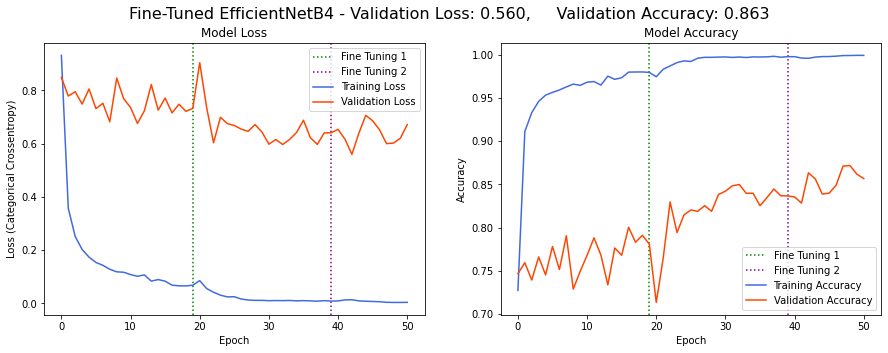

In [ ]:
evaluate_model(enet_model, enet_history, enet_val_ds, 'Fine-Tuned EfficientNetB4', 
               fine_tune=2, fine_history=[enet_history_fine1, enet_history_fine2], 
               fine_epoch=[enet_fine1_epochs, enet_fine2_epochs])

As seen here, the improvement in validation loss/accuracy was quite erratic but had a general downward trend (for loss). There was not a very drastic improvement when fine-tuning began as compared to VGG16 and the model actually achieved decent results even before fine-tuning, which indicates that the pre-trained model can perform well despite not being adapted to this particular image dataset.

## Model Evaluation

| Model          | Data              | Fine-Tuning | Test Score (Kaggle) | Val Loss | Val Accuracy | Initial Epochs | Fine-Tuning Epochs | Total Epochs |
|----------------|-------------------|-------------|---------------------|----------|--------------|----------------|----------------------------|--------------|
| VGG16          | Randomly Shuffled | No          | 1.78549             | 0.049    | 0.987        | 25             | -                          | 25           |
| VGG16          | Split by Driver   | Yes         | 0.68395             | 0.62     | 0.853        | 13             | 17 + 8                     | 38           |
| EfficientNetB4 | Split by Driver   | Yes         | 0.59852             | 0.560    | 0.863        | 19             | 21 + 9                     | 49           |

**EfficientNetB4** performs the best out of the models we tested in all metrics. Compared to the randomly shuffled data, we can see that the validation scores for models trained on the driver split data were worse and the training metrics quickly outperformed the validation metrics, in line with expected behaviour. However, their Kaggle test scores were much better. This confirms our hypothesis that the random shuffling of images was causing the model to overfit to the entire training dataset as their training and validation performance did not translate to good performance when exposed to unseen data.

We will proceed to form our final predictions on the test set and continue or analysis with the EfficientNetB4 model.

### Ensemble Predictions with KFold

Generally, there is no reason to cross-validate CNN models over multiple folds because the models are iteratively trained and tend to perform well regardless of how the data is shuffled and split. However, in this case, the data is not randomly shuffled but rather split by drivers. Thus, the CNN model is not exposed to certain unique drivers that are in the validation set and may lose out on the information from those images.

To expose the model to the maximum amount of information possible, we will use an ensemble method to create our final predictions. The model will be trained on image data and produce predictions from each different driver split, then the final predictions will be formed from the average of those predictions.

We will be using the fine-tuned EfficientNetB4 model.

In [ ]:
# Create a list of predictions, one for each fold
counter = 0
predict_list = []
imgsize = 380
batchsize = 128
num_classes = 10

for train_index, val_index in kf.split(fulltrain_driver_list):
    counter += 1

    # Instantiate empty df
    train_df = pd.DataFrame(columns=['subject', 'classname', 'img'])
    val_df = train_df.copy()

    # Fill train df with drivers in train split
    train_driver_list = [fulltrain_driver_list[i] for i in train_index]
    for train_driver in train_driver_list:
        train_df = filter_process_df(train_df, train_driver)

    # Fill val df with drivers in val split
    val_driver_list = [fulltrain_driver_list[i] for i in val_index]
    for val_driver in val_driver_list:
        val_df = filter_process_df(val_df, val_driver)
    
    # Create train & val datasets
    final_train_ds = create_img_dataset(train_df, imgsize, batchsize)
    final_val_ds = create_img_dataset(val_df, imgsize, batchsize)

    # Instantiate model - fine-tuned block 7b
    base_enet = EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(380, 380, 3),
        pooling='avg'
    )

    base_enet.trainable=False
    enet_input = base_enet.output
    x = Dropout(0.2)(enet_input)
    x = Dense(128, activation='relu')(x)
    enet_output = Dense(10, activation='softmax')(x)

    enet_final_model = Model(inputs=base_enet.input, outputs=enet_output)
    set_trainable_layers(enet_final_model, 22)

    # Compile and train model
    enet_final_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy'
    )

    final_checkpoint = checkpoint('enet_final_' + str(counter))

    enet_final_model.fit(
        final_train_ds,
        validation_data=final_val_ds,
        epochs=50,
        callbacks=[final_checkpoint, early_stop, reduce_lr]
    )

    # Save model
    model_name = '../models/final_model_fold_' + str(counter) + '.h5'
    enet_final_model.save(model_name, save_format='h5')

    # Make predictions on test dataset
    final_test_preds = enet_final_model.predict(enet_test_ds)

    # Create submission df
    final_test_sub = pd.DataFrame(final_test_preds, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    final_test_sub['img'] = sample_sub['img']
    final_test_sub = final_test_sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']]
    
    # Append predictions for this fold to list
    predict_list.append(final_test_sub)

Trainable Layers:

1: block7b_expand_conv
2: block7b_expand_activation
3: block7b_dwconv
4: block7b_activation
5: block7b_se_squeeze
6: block7b_se_reshape
7: block7b_se_reduce
8: block7b_se_expand
9: block7b_se_excite
10: block7b_project_conv
11: block7b_drop
12: block7b_add
13: top_conv
14: top_activation
15: avg_pool
16: dropout_3
17: dense_6
18: dense_7
Epoch 1/50
131/131 [==============================] - 178s 1s/step - loss: 0.4694 - val_loss: 0.7823

Epoch 00001: val_loss improved from inf to 0.78226, saving model to ../models/checkpoints/enet_final_1_checkpoint.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
131/131 [==============================] - 167s 1s/step - loss: 0.1110 - val_loss: 0.5726

Epoch 00002: val_loss improved from 0.78226 to 0.57260, saving model to ../models/checkpoints/enet_final_1_checkpoint.hdf5
Epoch 3/50
131/131 [==============================] - 167s 1s/step - loss: 0.0660 - val_loss: 0.5375

Epoch 00003: val_loss improved from 0.57260 to 0.53749, saving model to ../models/checkpoints/enet_final_1_checkpoint.hdf5
Epoch 4/50
131/131 [==============================] - 167s 1s/step - loss: 0.0551 - val_loss: 0.7105

Epoch 00004: val_loss did not improve from 0.53749
Epoch 5/50
131/131 [==============================] - 167s 1s/step - loss: 0.0487 - val_loss: 0.8880

Epoch 00005: val_loss did not improve from 0.53749
Epoch 6/50
131/131 [==============================] - 167s 1s/step - loss: 0.0404 - val_loss: 0.6812

Epoch 00006: val_loss did not improve from 0.53749
Epoch 7/50
131/131 [==============================] - 167s 1s/step - loss: 0.0395 - val_los

In [ ]:
# Combine predictions & average for all folds to create final submission
comb_final = pd.concat(predict_list, ignore_index=False)
final_submission = comb_final.groupby(comb_final.img).mean().reset_index()
final_submission.head()

img            c0  ...            c8            c9
0       img_1.jpg  4.052218e-03  ...  2.707094e-04  2.456000e-01
1      img_10.jpg  5.433623e-02  ...  4.149611e-04  9.090366e-05
2     img_100.jpg  3.896371e-01  ...  2.694570e-02  9.608397e-02
3    img_1000.jpg  1.608984e-09  ...  9.932107e-01  1.433976e-05
4  img_100000.jpg  4.136155e-11  ...  4.310749e-14  1.062738e-12

[5 rows x 11 columns]

In [ ]:
# Save final submissions
final_submission.to_csv('../data/final_submission.csv', index=False)

#### Final Kaggle Score

**0.30096**

As expected, using this ensemble method improved our results significantly as the model was exposed to more information while training.

### Confusion Matrix

As further evaluation of our best performing model, we can plot & analyse the confusion matrix to see how our model performs for each class.

In [ ]:
# Create predictions for validation set
val_preds = enet_model.predict(enet_val_ds)
val_preds = val_preds.argmax(axis=-1)

In [ ]:
# Actual validation set values
val_true = np.concatenate([label for x, label in enet_val_ds]).argmax(axis=-1)

In [ ]:
# Create confusion matrix, normalise for ease of understanding
cm = confusion_matrix(val_true, val_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# Create labels for axes
class_labels = []
for key, value in class_dict.items():
    class_labels.append(f'{key}: {value}')

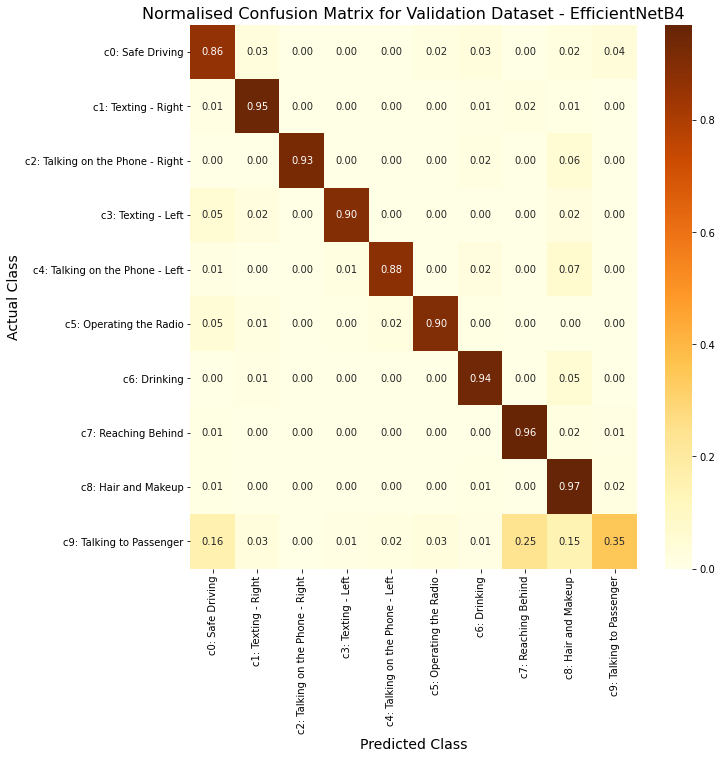

In [ ]:
# Create function to plot confusion matrix
def plot_cm(con_mat, title):
    plt.figure(figsize=(10,10))

    sns.heatmap(
        con_mat,
        annot=True,
        fmt='.2f',
        xticklabels=class_labels,
        yticklabels=class_labels,
        cmap='YlOrBr'
    )

    plt.xlabel('Predicted Class', fontsize=14)
    plt.ylabel('Actual Class', fontsize=14)
    plt.title(title, fontsize=16);

plot_cm(cm_norm, 'Normalised Confusion Matrix for Validation Dataset - EfficientNetB4')

As seen above, our model generally performs well for all class except for `c9: Talking to Passenger`. This was one of the classes we had mentioned during the EDA that was quite similar to other classes (`c0` and `c8`), and we can see that a big proportion of misclassifications was actually due to predicted values from these two classes. 

Another interesting thing to note is that there were a lot of `c9` images that were predicted as `c7: Reaching Behind` as well, even though we would have thought that the arm reaching behind would be an obvious signal. Perhaps this could be due to the angle of the driver's body which is rather similar for both classes.

### Further Analysis of Misclassifications

We will visualise misclassifications for each class to see if there are any patterns that cause them to be misclassified.

In [ ]:
# Add predictions to validation df
val_df['enet_preds'] = val_preds
val_df.head()

subject classname  ... classnumber enet_preds
0    p026        c2  ...           2          2
1    p045        c8  ...           8          8
2    p075        c3  ...           3          8
3    p050        c4  ...           4          4
4    p050        c8  ...           8          8

[5 rows x 6 columns]

In [ ]:
# Filter misclassified images
val_misclass = val_df[val_df['classnumber'] != val_df['enet_preds']]\
    .reset_index(drop=True)
val_misclass.head()

subject classname  ... classnumber enet_preds
0    p075        c3  ...           3          8
1    p041        c9  ...           9          0
2    p035        c2  ...           2          8
3    p045        c2  ...           2          8
4    p075        c9  ...           9          1

[5 rows x 6 columns]

In [ ]:
val_misclass[val_misclass['classname'] == 'c0'].sample(n=1)['img_path'].values[0]

'/root/.keras/datasets/train/c0/img_78805.jpg'

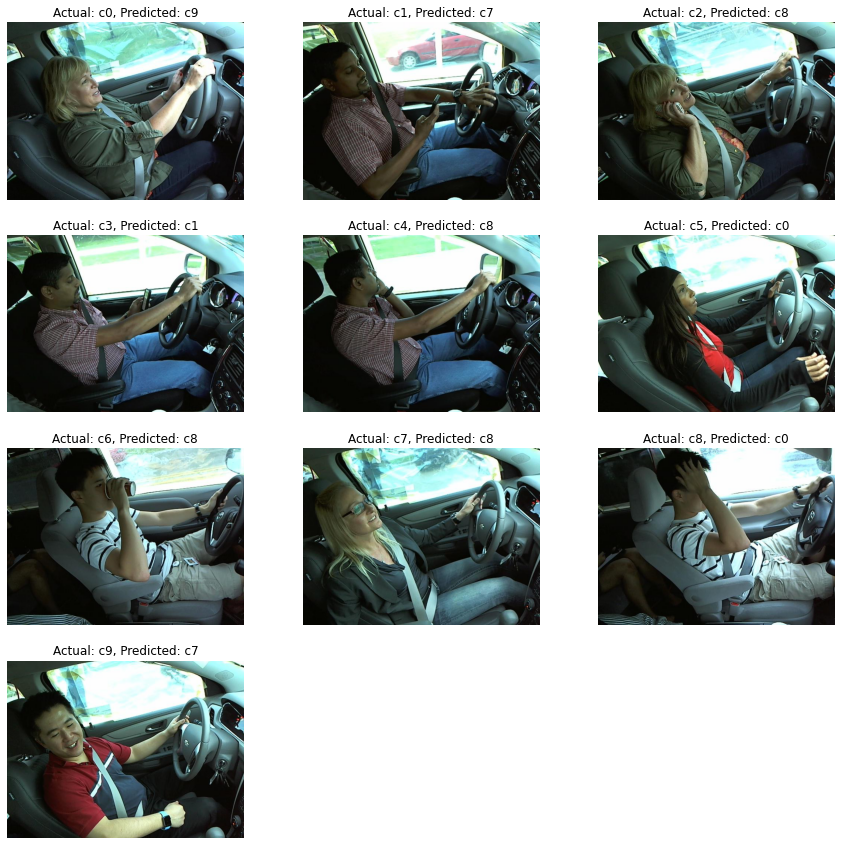

In [ ]:
# Visualise sample misclassifications for each class
plt.figure(figsize=(15,15))

for i, class_ in enumerate(classes):
    ax = plt.subplot(4, 3, i + 1)
    row = val_misclass[val_misclass['classname'] == class_].sample(n=1)
    pred = 'c' + str(row['enet_preds'].values[0])
    im_path = row['img_path'].values[0]
    image = mpimg.imread(im_path)
    plt.imshow(image)
    plt.title(f'Actual: {class_}, Predicted: {pred}')
    plt.axis('off')

After observing some examples of misclassifications, we notice some possible sources of ambiguity for each class that might be the reason why the model is unable to classify some images correctly.

| Class | Definition                   | Possible Sources of Ambiguity                              |
|-------|------------------------------|------------------------------------------------------------|
| c0    | Safe Driving                 | Turning steering wheel changes body angle                  |
| c1    | Texting - Right              | Angle of arms still quite straight, phone not very visible |
| c2    | Talking on the Phone - Right | Arm angle similar to drinking, body angle opens up         |
| c3    | Texting - Left               | Phone & left arm not very visible                          |
| c4    | Talking on the Phone - Left  | Phone not very visible, arm looks like touching face       |
| c5    | Operating the Radio          | Arm not always outstretched to radio                       |
| c6    | Drinking                     | Cup not very obvious, arm angle varies a lot               |
| c7    | Reaching Behind              | Body angle varies, arm not very visible                    |
| c8    | Hair and Makeup              | Arm angle looks like drinking                              |
| c9    | Talking to Passenger         | Rotation of head and body not very obvious                 |

This is particularly noticeable for class `c9: Talking to Passenger`, where there is no distinct characteristic that is unique to the class. This is in line with our findings earlier on where `c9` is the most misclassified class.

Additionally, we can also see that the labels are not always consistent for ambiguous images. There are some images that seem to belong in between classes and these are quite commonly misclassified.

### Test on Unseen External Data

We can test our model even more by examining its performance when exposed to unseen external data that is not curated from the experiment.

In [ ]:
# Download data & create directory path to images
ext_zip = 'file:/content/drive/MyDrive/distracted_driver_detection/data/images/test_external.zip'
ext_zip_dir = tf.keras.utils.get_file(fname='ext_zip', origin=ext_zip, extract=True)
ext_dir = os.path.join(os.path.dirname(ext_zip_dir), 'test_external')
print(ext_dir)

16662528/16662158 [==============================] - 1s 0us/step
/root/.keras/datasets/test_external


In [ ]:
# Check keras cache
!ls /root/.keras/datasets

ext_zip  test  test_external  test_zip	train  train_zip


In [ ]:
# Create dataset
external_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ext_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=128,
    image_size=(380, 380),
    shuffle=False
)

Found 63 files belonging to 10 classes.


In [ ]:
# Check classes
external_ds.class_names

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

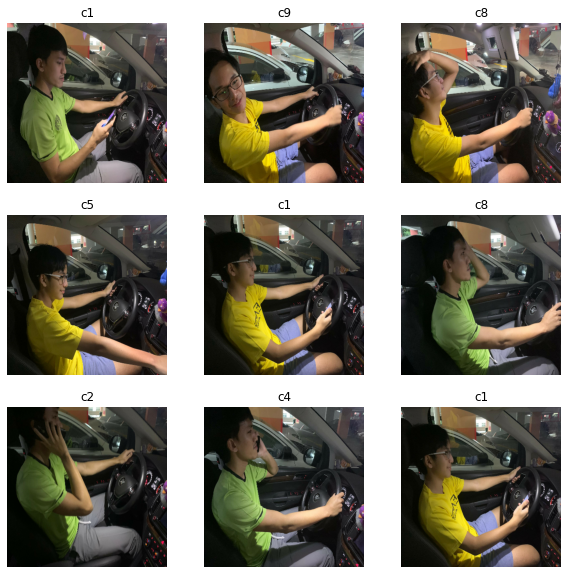

In [ ]:
# Visualising random 9 images in external test dataset
plt.figure(figsize=(10, 10))
for images, labels in external_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        index = random.randint(0, 62)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[index])])
        plt.axis("off")

In [ ]:
enet_model.evaluate(external_ds)

1/1 [==============================] - 2s 2s/step - loss: 2.8518 - accuracy: 0.4286


[2.8517873287200928, 0.4285714328289032]

Our model actually does not perform very well with external image data that is not from the same curated experiment. The different lighting, location, car and camera angle seem to negatively affect the model's performance.

#### Confusion Matrix

In [ ]:
ext_preds = enet_model.predict(external_ds).argmax(axis=-1)
ext_true = np.concatenate([label for x, label in external_ds]).argmax(axis=-1)
ext_cm = confusion_matrix(ext_true, ext_preds)
ext_cm_norm = ext_cm.astype('float') / ext_cm.sum(axis=1)[:, np.newaxis]

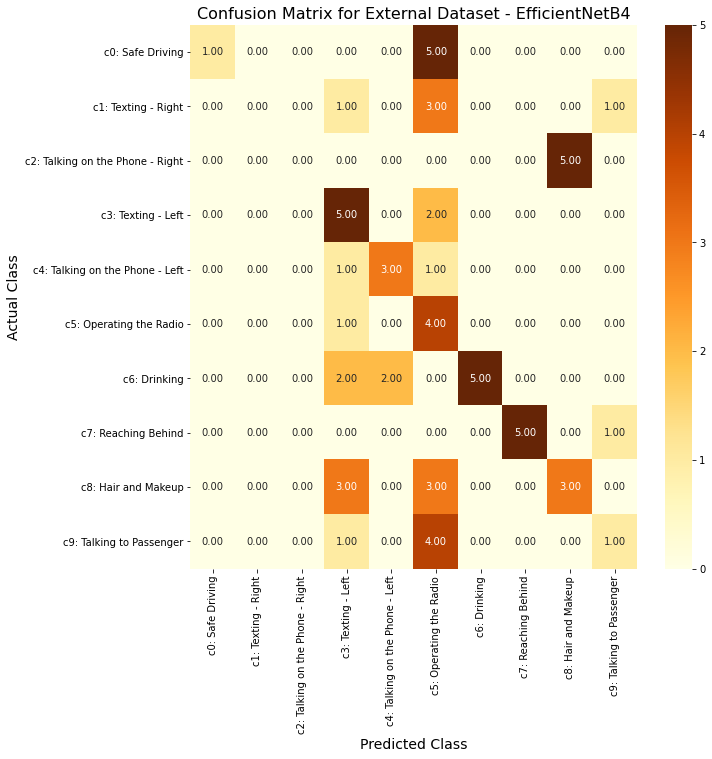

In [ ]:
plot_cm(ext_cm, 'Confusion Matrix for External Dataset - EfficientNetB4')

The confusion matrix further confirms that our model does not perform well to external unseen data. Some classes (`c1`, `c2`) do not even have any correct predictions!

## Conclusion



In this project, we successfully created a CNN model which managed to achieve a multiclass log loss score of **0.301**. Preprocessing of the train dataset proved to be a major factor in improving the model's performance in predicting images from unseen drivers.

### Real World Applicability

As explored above, the model is not robust enough to be useful in a real world scenario due to the uniformity of the base dataset that it was trained and evaluated on. All the images were curated from a controlled experiment, so the model was not able to generalise well to images that were not similar to images from the experiment.

However, this project showed that detecting a driver's distraction state through image data (e.g. from dashboard cameras) is definitely a feasible concept, and with further development the model could be applied in certain ways to help improve road safety.

Some possible applications include:

1. Providing useful information to insurance companies, who can craft data-driven policies that incentivise distraction-free driving. The model could be applied to dashboard cameras to relate the percentage of time a driver spends between safe/distracted states.

2. Provide real time feedback to drivers who may unknowingly lose focus. As discussed at the start, most drivers agree that being distracted is an unsafe practice. However, due to muscle memory and convenience, many drivers still subconsciously engage in distracted activities such as using the phone and operating the radio. Implementing the model could enable the dashboard cameras to emit a sound or blink whenever it detects the driver being distracted for a few seconds, helping them to focus more on the road.

### Recommendations for Future Work


In order to improve the model's performance on unseen external data, a few things could be done so that the model would be more generalisable:
1. Using grayscale photos to further reduce the signal from individual drivers' features

2. Implement image augmentation to account for differing image sources, e.g. left-hand drive, right-hand drive, different camera angles, etc.

3. Gather more data from varied sources, e.g. different types of cars, images taken at night, drivers wearing masks, etc.

To develop its practicality with regards to dashboard cameras, the model could also be developed to perform well in real time on videos.